<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_9_3_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot --quiet

In [ ]:
#@title The Imports
from tensorflow.keras.datasets import mnist as data
#from tensorflow.keras.datasets import fashion_mnist as data

#from tensorflow.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from tqdm import tqdm_notebook

import random
from tqdm.notebook import tqdm as tqdm

In [ ]:
#@title Load and Normalize Training/Test Data
(train_images, train_labels), (test_images, test_labels) = data.load_data()

# split dataset
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
print(train_images.shape)

# Rescale -1 to 1
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=3)
print(train_images.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
#@title Extract Class of Images
def extract(images, labels, class_):
  idx = labels == class_
  print(idx)
  imgs = images[idx]
  print(imgs.shape)
  return imgs

train_images = extract(train_images, train_labels, 5)

[ True False False ...  True False False]
(5421, 28, 28, 1)


In [ ]:
#@title Internal Hyperparameters and Optimizers Setup
latent_dim = 100

gen_optimizer = RMSprop(lr=0.00005)
critic_optimizer = RMSprop(lr=0.00005)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
#@title Wasserstein Loss Function
def wasserstein_loss(y_true, y_pred):
  return K.mean(y_true * y_pred)

In [ ]:
#@title Determine Base Convolution Size
cs = int(train_images.shape[1] / 4)
print(train_images.shape)
channels = train_images.shape[3]
img_shape = (train_images.shape[1], train_images.shape[2], channels)

(5421, 28, 28, 1)


In [ ]:
#@title Building the Generator (g)
def build_generator():
  model = Sequential()

  model.add(Dense(128 * cs * cs, activation="relu", input_dim=latent_dim))
  model.add(Reshape((cs, cs, 128)))
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=3, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(UpSampling2D())
  model.add(Conv2D(64, kernel_size=3, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(Conv2D(channels, kernel_size=3, padding="same"))
  model.add(Activation("tanh"))

  model.summary()

  noise = Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)
g = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 128)       0

In [ ]:
#@title Building the Discriminator (d)
def build_critic():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1))

  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

critic = build_critic()
critic.compile(loss=wasserstein_loss,
            optimizer=critic_optimizer,
            metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#@title Building the GAN
z = Input(shape=(latent_dim,))
img = g(z)

# For the combined model we will only train the generator
critic.trainable = False

# The discriminator takes generated images as input and determines validity
valid = critic(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
gan = Model(z, valid)
gan.compile(loss=wasserstein_loss, optimizer=gen_optimizer)

In [ ]:
#@title Plot Helper Functions    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, latent_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, img_shape[0], img_shape[1])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow((1-generated_images[i])*255, interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

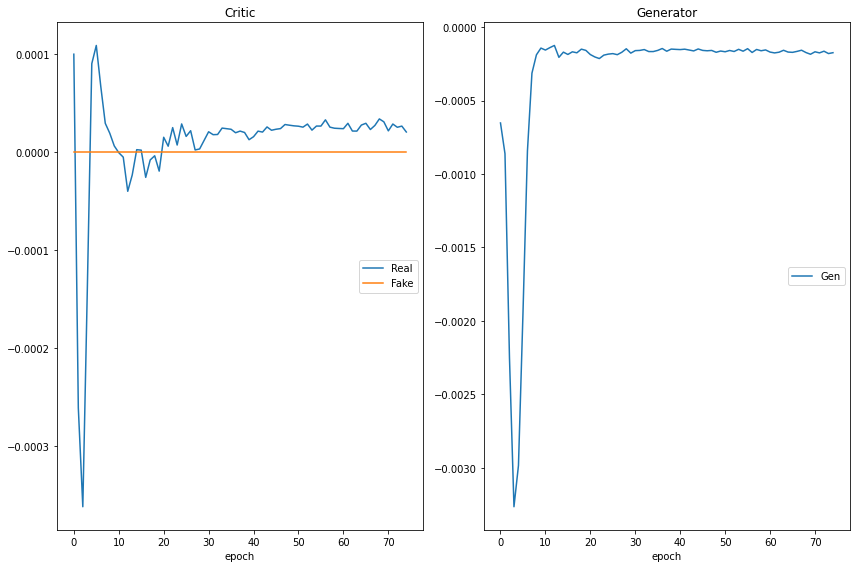

Critic
	Real             	 (min:   -0.000, max:    0.000, cur:    0.000)
	Fake             	 (min:    0.000, max:    0.000, cur:    0.000)
Generator
	Gen              	 (min:   -0.003, max:   -0.000, cur:   -0.000)


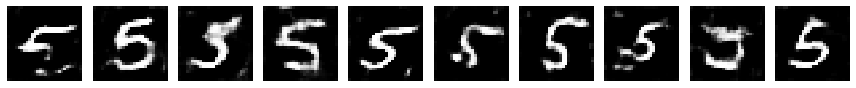

In [ ]:
#@title Training the GAN
EPOCHS = 75 #@param {type:"slider", min:5, max:100, step:1}
BATCH_SIZE = 256 #@param {type:"slider", min:64, max:256, step:2}
CRITIC_ITS = 5 #@param {type:"slider", min:1, max:10, step:1}

clip_value = .01

groups = { "Critic" : {"Real", "Fake"}, "Generator":{"Gen"}}
plotlosses = PlotLosses(groups=groups)

plt_frq = 1
batches = int(train_images.shape[0] / BATCH_SIZE)

# Adversarial ground truths
valid = -np.ones((BATCH_SIZE, 1))
fake = np.ones((BATCH_SIZE, 1))

for e in range(EPOCHS):
  for i in tqdm(range(batches)):
    for _ in range(CRITIC_ITS):
      # ---------------------
      #  Train Critic
      # ---------------------
      # Select a random half of images
      idx = np.random.randint(0, train_images.shape[0], BATCH_SIZE)
      imgs = train_images[idx]  

      # Sample noise and generate a batch of new images
      noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
      gen_imgs = g.predict(noise)

      # Train the critic (real classified as ones and generated as zeros)
      c_loss_real = critic.train_on_batch(imgs, valid)
      c_loss_fake = critic.train_on_batch(gen_imgs, fake)
      c_loss = 0.5 * np.add(c_loss_real, c_loss_fake)  
      
      #clip critic weights
      for l in critic.layers:
        weights = l.get_weights()
        weights = [np.clip(w, -clip_value, clip_value) for w in weights]
        l.set_weights(weights) 

    # ---------------------
    #  Train Generator
    # ---------------------
    # Train the generator (wants discriminator to mistake images as real)
    g_loss = gan.train_on_batch(noise, valid)  

  loss = dict(Real = c_loss[0], Fake = c_loss[1], Gen = g_loss)  
  plotlosses.update(loss)
  plotlosses.send()
  plot_generated()
